# XGB Quantile Loss

In [87]:
# Be sure to go to bottom to see functions called
# Because second derivative in XGBoost is zero, must add random noise to use quantile loss

# Technique from https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b
# and
# https://colab.research.google.com/drive/1KlRkrLi7JmVpprL94vN96lZU-HyFNkTq?usp=sharing


In [2]:
#standard
import numpy as np
np.random.seed(1) #fix seed for notebook
import pandas as pd
import scipy
import os
import datetime
from pathlib import Path
from collections import defaultdict
import xarray as xr
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import matplotlib.pyplot as plt
import pickle

#ML
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

#utils
from functools import partial

#plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Python file with supporting functions
import pre_SOCAT

In [5]:
# =========================================
# For accessing directories
# =========================================
root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC"

reference_output_dir = f"{root_dir}/references"
data_output_dir = f"{root_dir}/data/processed"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

approach = 'xg_quantile'
approach_output_dir = f"{other_output_dir}/{approach}"
# =========================================
# Number of cores you have access to for model training
# =========================================
jobs = 30

In [6]:
# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions for LET runs:
# Parameter grids
xg_param_grid = {"n_estimators":[1000, 2000, 3000],
                 "max_depth":[5,6,7,8],
                 "max_delta_step":[2,5,10],
                 
                }

# Feature and target lists for feeding into ML:
features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','A','B','C','T0','T1'] # pCO2_DIC
target_sel = ['pCO2_DIC']  # What we reconstruct with ML
final_sel = ['pCO2'] # What we want RMSE, etc. for (pCO2 = pCO2_DIC + pCO2_T)

In [7]:
# Want to train with 4 out of every 5 months, and test on the fifth month
date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2019-12-01T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')
select_dates = []
test_dates = []
for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i])
    if i % 5 == 0:
        test_dates.append(dates[i])
year_mon = []
for i in range(0,len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
test_year_mon = []
for i in range(0,len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

In [8]:
approach = 'xgb_quantile'
approach_output_dir = f"{other_output_dir}/{approach}"
random_seeds = [13,71] # pCO2_DIC
first_run = True

# Get X,Y we Need to Train, Test, Predict

In [11]:
if first_run:
    best_params = {} # Uncomment if running cross validation to find best params
else:
    param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
    with open(param_fname, 'rb') as handle:
        best_params = pickle.load(handle)
    
test_performance = defaultdict(dict)

K_folds = 3

print(datetime.datetime.now())

# Data file path
data_dir = f"{data_output_dir}"
fname = f"data_clean_2D_mon_1x1_198201-201912.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
df = pd.read_pickle(file_path)

# Get rid of features we never use:
df = df.drop(columns=['chl','mld'])

# Test on every fifth month to reduce autocorrelation along cruise tracks, but still sample many climate anomalies...
df['year'] = df.index.get_level_values('time').year
df['mon'] = df.index.get_level_values('time').month
df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)

# Get rid of N    
recon_sel = (~df[features_sel+['net_mask']].isna().any(axis=1))   # Dont' have dpCO2 for non-SOCAT locations, but have features

# Try (200,-250) as cut off based on histogram plots of SOCAT data:
################################################################################################################################        
sel = (recon_sel & (df['socat_mask'] == 1)) & ((df['pCO2'] < 650)).to_numpy().ravel()           # locations not masked AND IN SOCAT SAMPLING and within reason

print("SOCAT length =",sum(sel))

###################################################################################################################################
# Separate the data sets
###################################################################################################################################
train_val_sel = ((sel) & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
print("Train/Val length = ",sum(train_val_sel))

test_sel = ((sel) & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()   # Should be along SOCAT track
print("Test length =",sum(test_sel))     

################################################################################################################################
# Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()         
y = df.loc[sel,target_sel].to_numpy().ravel()

# Where we want dpCO2 reconstructed
X_recon = df.loc[recon_sel,features_sel].to_numpy()         

#X_train, X_val, y_train, y_val = mselect.train_test_split(X_train_val, y_train_val, test_size=val_prop, random_state=42)  
# Convert dataframe to numpy arrays, train/val/test split
X_train_val = df.loc[train_val_sel,features_sel].to_numpy()                # create Xtrain and Xtest to randomly select from for X_train and X_test
y_train_val = df.loc[train_val_sel,target_sel].to_numpy().ravel()

print(datetime.datetime.now())

2021-12-22 13:57:23.767773
SOCAT length = 262710
Train/Val length =  209961
Test length = 52749
2021-12-22 14:01:02.791947


In [48]:
estimator = XGBQuantile(quant_alpha = 0.95,quant_delta=5.0, quant_thres = 5.0 ,quant_var=4.0, n_estimators=1500, max_depth=5)
print(estimator)

XGBQuantile(quant_delta=5.0, quant_thres=5.0, quant_var=4.0)


In [77]:
# Find parameters for Upper Bounds (alpha = 0.95)
gs_upper  = RandomizedSearchCV(estimator = estimator, 
                        param_distributions={
                                  'quant_delta':scipy.stats.uniform(0.01,100.0),
                                  'quant_var':scipy.stats.uniform(1.0,100.0),
                                  'quant_thres':scipy.stats.uniform(0.01,100.0)
                        },n_iter=100,n_jobs=5,cv=K_folds,return_train_score=False,pre_dispatch=1,verbose=3)
print(gs_upper)
gs_upper.fit(X_train_val,y_train_val)

print(gs_upper.best_params_)

RandomizedSearchCV(cv=3,
                   estimator=XGBQuantile(quant_delta=5.0, quant_thres=5.0,
                                         quant_var=4.0),
                   n_iter=100, n_jobs=5,
                   param_distributions={'quant_delta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f783e0208>,
                                        'quant_thres': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f783e0588>,
                                        'quant_var': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f783e00b8>},
                   pre_dispatch=1, verbose=3)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 80.8min
[Parallel(n_jobs=5)]: Done 127 tasks      | elapsed: 342.3min
[Parallel(n_jobs=5)]: Done 287 tasks      | elapsed: 756.9min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed: 791.0min finished


{'quant_delta': 10.178208405163604, 'quant_thres': 91.49541051056248, 'quant_var': 16.077370696856484}


In [78]:
upper_best_params = gs_upper.best_params_

In [79]:
print(upper_best_params)

{'quant_delta': 10.178208405163604, 'quant_thres': 91.49541051056248, 'quant_var': 16.077370696856484}


In [17]:
################ TEST ####################################################################################################
X_test = df.loc[test_sel,features_sel].to_numpy()                #  Test metrics on all of SOCAT data from test years
y_test = df.loc[test_sel,target_sel].to_numpy().ravel()

In [30]:
# XGBoost!

regressor = XGBRegressor(reg_alpha=5, reg_lambda=1,gamma=0.5,n_jobs=30)
y_pred_test = regressor.fit(X_train_val,y_train_val).predict(X_test)
test_performance = pre_SOCAT.evaluate_test(y_test, y_pred_test)
print(test_performance)
y_pred_all = regressor.fit(X_train_val,y_train_val).predict(X_recon)

{'mse': 260.45381653008604, 'mae': 10.853762506859285, 'medae': 7.419853765533674, 'max_error': 176.0990028002031, 'bias': 0.21753270169899963, 'r2': 0.8442206583114492, 'corr': 0.91886828409821, 'cent_rmse': 16.137115477808738, 'stdev': 37.913956, 'amp_ratio': 0.9961918243129756, 'stdev_ref': 40.889371082588895, 'range_ref': 399.4094490875581, 'iqr_ref': 44.526950407469656}


In [80]:
# Upper Bounds
#regressor_upper = XGBQuantile(n_estimators=1344,max_depth = 4, reg_alpha =5.0,gamma = 0.5,reg_lambda =1.0, n_jobs=30)     
regressor_upper = XGBQuantile(n_jobs=30)     
regressor_upper.set_params(quant_alpha=0.95,quant_delta=10.17,quant_thres=91.50,quant_var=16.08)
y_upper_test = collect_prediction(X_train_val,y_train_val,X_test,y_test,estimator=regressor_upper,alpha=0.95,model_name="Quantile XGB")
y_upper_recon = regressor_upper.fit(X_train_val,y_train_val).predict(X_recon)

Quantile XGB alpha = 0.95,score = 112375.6


In [67]:
# Get Params for Lower Bounds:

estimator_lower = XGBQuantile(quant_alpha = 0.05,quant_delta= 5.0, quant_thres = 5.0 ,quant_var=4.0)
gs_lower  = RandomizedSearchCV(estimator = estimator_lower, 
                        param_distributions={
                                  'quant_delta':scipy.stats.uniform(0.01,100.0),
                                  'quant_var':scipy.stats.uniform(1.0,100.0),
                                  'quant_thres':scipy.stats.uniform(0.01,100.0)},
                         n_iter=100,n_jobs=5,cv=K_folds,return_train_score=True,pre_dispatch=1,verbose=3)

print(gs_lower)
gs_lower.fit(X_train_val,y_train_val)
print(gs_lower.best_params_)
lower_best_params = gs_lower.best_params_

RandomizedSearchCV(cv=3,
                   estimator=XGBQuantile(quant_alpha=0.05, quant_delta=5.0,
                                         quant_thres=5.0, quant_var=4.0),
                   n_iter=100, n_jobs=30,
                   param_distributions={'quant_delta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f69bafa20>,
                                        'quant_thres': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f69bafd30>,
                                        'quant_var': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f69baff28>},
                   pre_dispatch=1, return_train_score=True, verbose=3)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  31 tasks      | elapsed: 82.8min
[Parallel(n_jobs=30)]: Done 127 tasks      | elapsed: 338.2min
[Parallel(n_jobs=30)]: Done 287 tasks      | elapsed: 766.7min
[Parallel(n_jobs=30)]: Done 300 out of 300 | elapsed: 802.4min finished


{'quant_delta': 48.90268283735166, 'quant_thres': 94.48456677774611, 'quant_var': 3.346223600794406}


In [68]:
print(lower_best_params)

{'quant_delta': 48.90268283735166, 'quant_thres': 94.48456677774611, 'quant_var': 3.346223600794406}


In [70]:
# Lower Bounds
#regressor_low = XGBQuantile(n_estimators=1498,max_depth = 5, reg_alpha =5.0,gamma = 0.5,reg_lambda =1.0, n_jobs=30)     
regressor_low = XGBQuantile(n_estimators=1500,max_depth=5, n_jobs=30)     
regressor_low.set_params(quant_alpha=0.05,quant_delta=48.9,quant_thres=94.48,quant_var=3.35)
print(regressor_low)
y_lower_test = collect_prediction(X_train_val,y_train_val,X_test,y_test,estimator=regressor_low,alpha=0.05,model_name="Quantile XGB")
y_lower_recon = regressor_low.fit(X_train_val,y_train_val).predict(X_recon)

XGBQuantile(quant_alpha=0.05, quant_delta=48.9, quant_thres=94.48,
            quant_var=3.35)
Quantile XGB alpha = 0.05,score = 149514.6


In [81]:
# Uncertainty Range (90% confidence interval):
y_range_recon = y_upper_recon - y_lower_recon

In [82]:
# Full reconstruction ##
df['pCO2_DIC_upper'] = np.nan
df.loc[recon_sel,['pCO2_DIC_upper']] = y_upper_recon 

df['pCO2_DIC_lower'] = np.nan
df.loc[recon_sel,['pCO2_DIC_lower']] = y_lower_recon   

df['pCO2_DIC_range'] = np.nan
df.loc[recon_sel,['pCO2_DIC_range']] = y_range_recon

df['pCO2_DIC_test'] = np.nan
df.loc[test_sel,['pCO2_DIC_test']] = y_test 

df['pCO2_DIC_test_upper'] = np.nan
df.loc[test_sel,['pCO2_DIC_test_upper']] = y_upper_test 

df['pCO2_DIC_test_lower'] = np.nan
df.loc[test_sel,['pCO2_DIC_test_lower']] = y_lower_test 

DS_recon = df[['net_mask','socat_mask','pCO2_DIC','pCO2_DIC_test','pCO2_DIC_test_lower','pCO2_DIC_test_upper','pCO2_DIC_upper','pCO2_DIC_lower','pCO2_DIC_range','pCO2','pCO2_T']].to_xarray()

########## SAVE ####################################################################################################
pre_SOCAT.save_recon(DS_recon, recon_output_dir, approach)   # Uncomment when actually running

Starting reconstruction saving process
Save complete


In [89]:
import cmocean as cm  

Text(0.5,1,'XGBoost 90% Confidence')

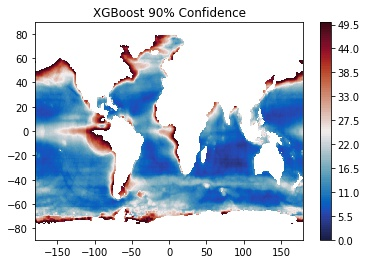

In [96]:
fig = plt.figure()
plt.contourf(DS_recon.xlon,DS_recon.ylat,DS_recon.pCO2_DIC_range.mean("time").transpose()/2,levels=np.linspace(0,50,101),cmap=cm.cm.balance)
plt.colorbar()
plt.title('XGBoost 90% Confidence')

In [ ]:
# Save the model
pre_SOCAT.save_model(lower_model, model_output_dir, approach)   #Uncomment when actually running
######################################################################################

In [43]:
#@title XGBQuantile Class
class XGBQuantile(XGBRegressor):
    def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=5, min_child_weight=1, missing=None, n_estimators=1500,
                n_jobs=jobs, nthread=None, objective='reg:squarederror', random_state=random_seeds[0],reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
    
        super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
           colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
           max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
           n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
           reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
           silent=silent, subsample=subsample)
    
        self.test = None
  
    def fit(self, X, y):
        super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
        super().fit(X,y)
        return self
  
    def predict(self,X):
        return super().predict(X)
  
    def score(self, X, y):
        y_pred = super().predict(X)
        score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
        score = 1./score
        return score
      
    @staticmethod
    def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
        grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
        hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
        return grad, hess
  
    @staticmethod
    def original_quantile_loss(y_true,y_pred,alpha,delta):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess

  
    @staticmethod
    def quantile_score(y_true, y_pred, alpha):
        score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
        score = np.sum(score)
        return score
  
    @staticmethod
    def quantile_cost(x, alpha):
        return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
    @staticmethod
    def get_split_gain(gradient,hessian,l=1):
        split_gain = list()
        for i in range(gradient.shape[0]):
            split_gain.append(np.sum(gradient[:i])**2/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])**2/(np.sum(hessian[i:])+l)-np.sum(gradient)**2/(np.sum(hessian)+l) )
    
        return np.array(split_gain)

In [44]:
def collect_prediction(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )

    return y_pred